In [161]:
from model_vae import CVAE, cvae_loss, cvae_loss_each
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from vae_earlystopping import EarlyStopping
from torch.utils.data import  DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt

x_data = np.load('./data/metal.npy',allow_pickle = True)
c_data = np.load('./data/reaction.npy',allow_pickle = True)
sup_data = np.load('./data/support.npy',allow_pickle=True)


ImportError: cannot import name 'cvae_loss_each' from 'model_vae' (c:\Users\User\Desktop\intern_practicing\model_vae.py)

## 데이터 train,val,test 6:2:2로 일단 unshuffle로 나누기

In [133]:
## train,test,validation_data 만들기
from sklearn.model_selection import train_test_split
x_train,x_test,c_train,c_test = train_test_split(x_data,c_data,test_size = 0.4,shuffle = False)
x_val,x_test,c_val,c_test = train_test_split(x_test,c_test,test_size = 0.5,shuffle= False)
print(x_train.shape,c_val.shape,x_test.shape) #0.6 #0.2 #0.2로 데이터 분류


(3544, 24) (1182, 9) (1182, 24)


# 데이터 scaler로 정리하기

In [134]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_c = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_val_s = scaler_x.transform(x_val)
x_test_s = scaler_x.transform(x_test)
c_train_s = scaler_c.fit_transform(c_train)
c_val_s = scaler_c.transform(c_val)
c_test_s = scaler_c.transform(c_test)

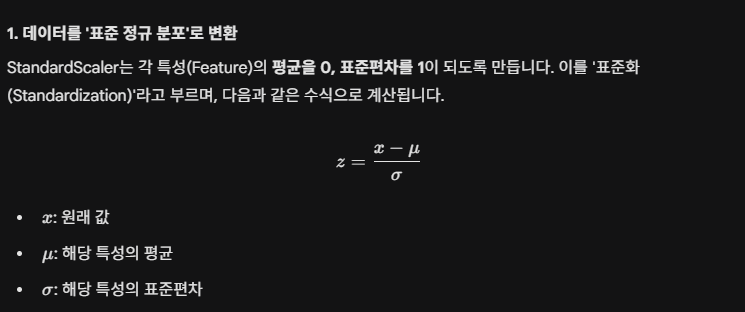

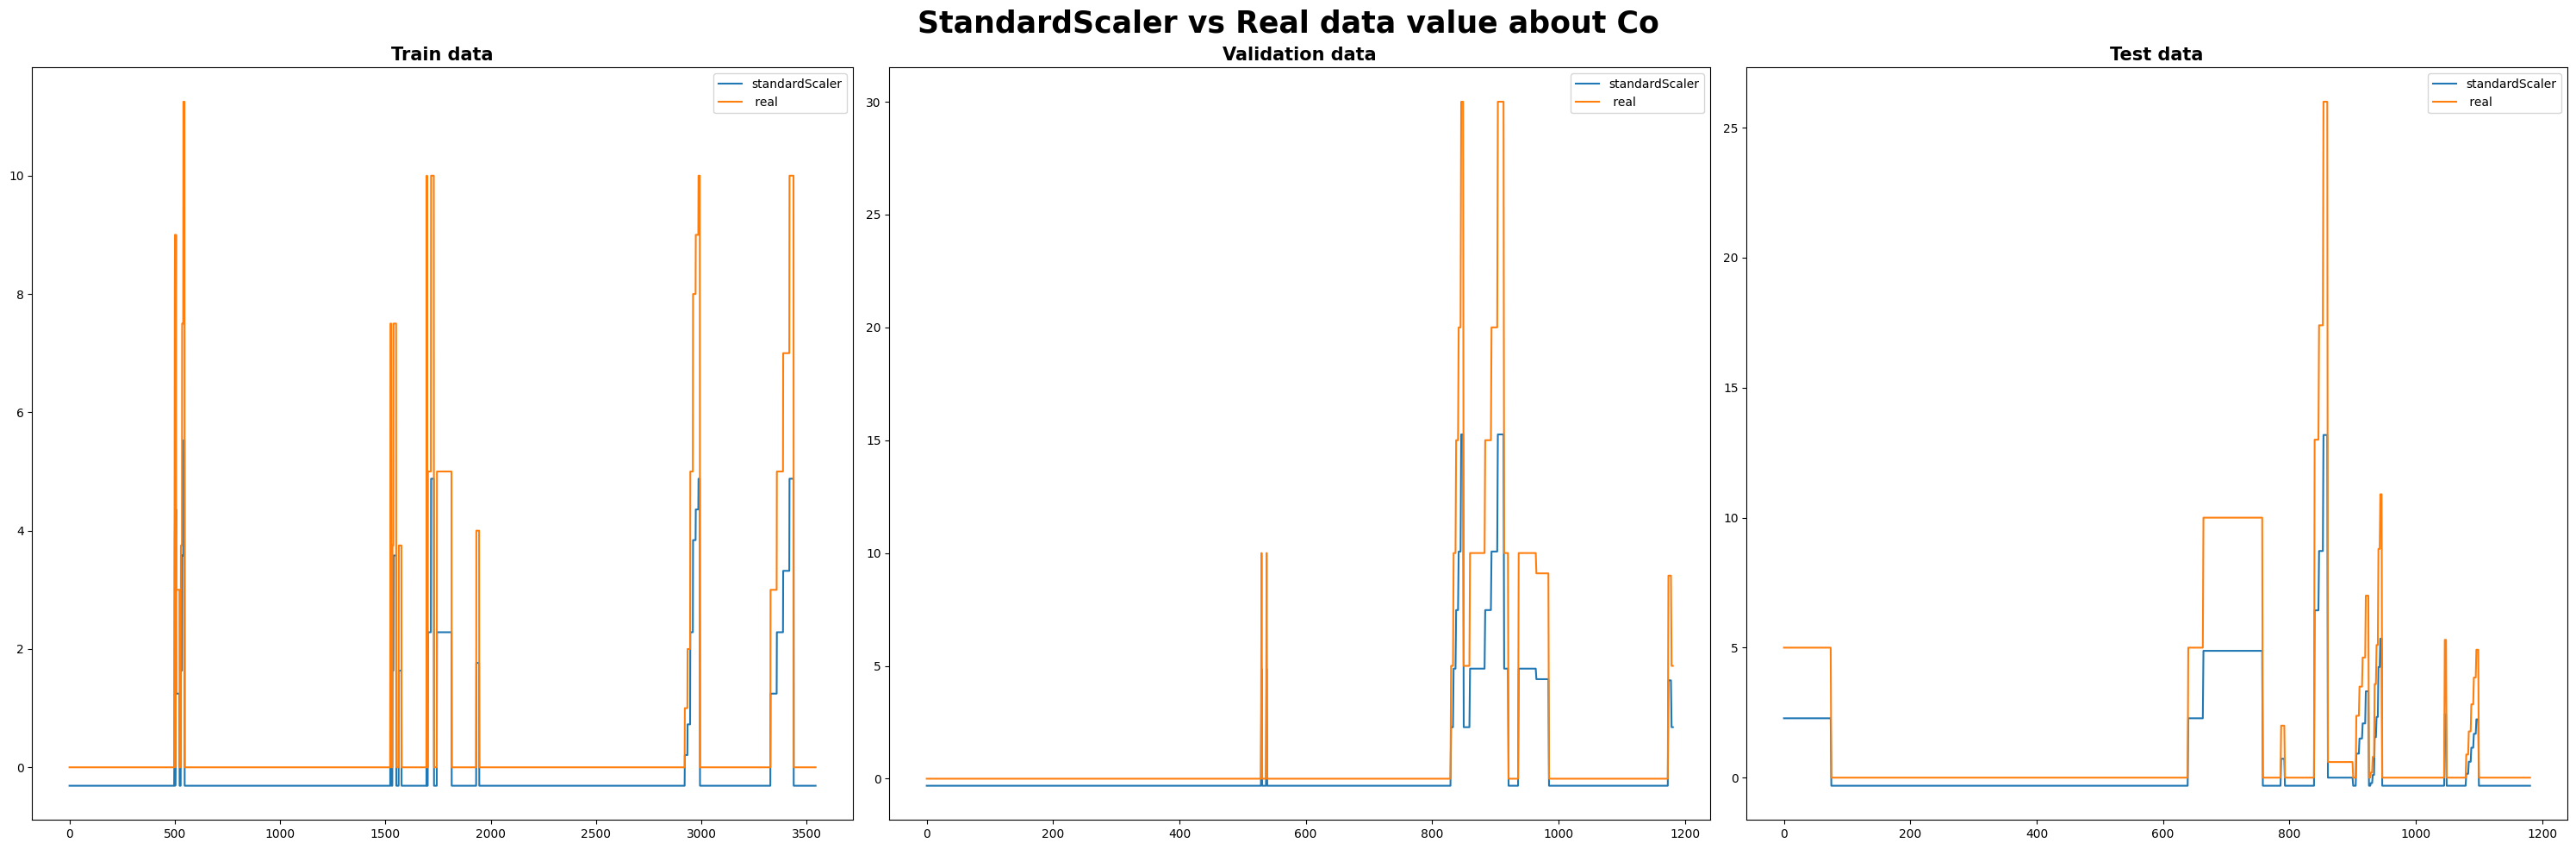

In [135]:
fig, axes = plt.subplots(1,3,figsize=(30,10))
x_datas = [x_train_s,x_val_s,x_test_s]
real_x_datas = [x_train,x_val,x_test]
names = ['Train', 'Validation', 'Test']
axes.flatten()
for i,x in enumerate(x_datas):
    ax = axes[i]
    ax.plot(x[:,1],label = 'standardScaler')
    ax.plot(real_x_datas[i][:,1],label =' real')
    ax.legend()
    ax.set_title(f'{names[i]} data',fontsize = 15,fontweight = 'bold')
plt.suptitle('StandardScaler vs Real data value about Co',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.show()
    
    

## scaler데이터 numpy에서 tensor로 바꾸기

In [145]:
x_train_s = torch.tensor(x_train_s, dtype=torch.float32)
x_val_s   = torch.tensor(x_val_s,   dtype=torch.float32)
x_test_s  = torch.tensor(x_test_s,  dtype=torch.float32)

c_train_s = torch.tensor(c_train_s, dtype=torch.float32)
c_val_s   = torch.tensor(c_val_s,   dtype=torch.float32)
c_test_s  = torch.tensor(c_test_s,  dtype=torch.float32)

C:\Users\User\AppData\Local\Temp\ipykernel_2092\803935989.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_s = torch.tensor(x_train_s, dtype=torch.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_2092\803935989.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_s   = torch.tensor(x_val_s,   dtype=torch.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_2092\803935989.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_s  = torch.tensor(x_test_s,  dtype=torch.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_

## 그냥 데이터 numpy에서 tensor로 바꾸기

In [146]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val   = torch.tensor(x_val,   dtype=torch.float32)
x_test  = torch.tensor(x_test,  dtype=torch.float32)

c_train = torch.tensor(c_train, dtype=torch.float32)
c_val   = torch.tensor(c_val,   dtype=torch.float32)
c_test  = torch.tensor(c_test,  dtype=torch.float32)

C:\Users\User\AppData\Local\Temp\ipykernel_2092\2604600074.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_2092\2604600074.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val   = torch.tensor(x_val,   dtype=torch.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_2092\2604600074.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test  = torch.tensor(x_test,  dtype=torch.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_2092\2604

## model에 넣고 학습시키기

In [147]:
x_dim = x_train.shape[1]
c_dim = c_train.shape[1]

## cvae 모델에서 x_train, c_train
- case1:x_train,c_train
- case2:x_train_s,c_train_s

### case1:x_train,c_train

In [154]:
model = CVAE(x_dim = x_dim,c_dim = c_dim,z_dim = 16)
x_hat,mu, logvar = model(x_train,c_train) # 그냥 x_train,c_train으로 학습시킨 값
# x_hat = x_hat.detach().cpu().numpy()
# x_hat = scaler_x.inverse_transform(x_hat)
# x_hat = torch.tensor(x_hat, dtype=torch.float32)
cvae_loss(x_hat,x_train,mu,logvar,beta = -0.01)


(tensor(nan, grad_fn=<AddBackward0>),
 tensor(nan, grad_fn=<MseLossBackward0>),
 tensor(inf, grad_fn=<MeanBackward0>))

### case2:x_train_s,c_train_s

In [158]:
x_hat,mu, logvar = model(x_train_s,c_train_s) # 그냥 x_train_s,c_train_s로 학습시킨 값
cvae_loss_each(x_hat,x_train_s,mu,logvar,beta = -0.01) 


NameError: name 'cvae_loss_each' is not defined

In [ ]:
df = pd.read_csv('211210-DRM-total.csv')
metal_columns = df.iloc[:,1:25].columns
metal_columns

Index(['Perovskite', 'Co', 'Ba', 'Ca', 'Cu', 'Ce', 'Mn', 'La', 'Ni', 'Ag',
       'Pt', 'Mg', 'Ir', 'Au', 'K', 'Li', 'Ru', 'Rh', 'Fe', 'Pr', 'Pd', 'Sr',
       'Y', 'Zr'],
      dtype='object')

In [ ]:
def cvae_loss_each(x_hat,x,mu,logvar,beta = 0.01):
    losses=[]
    recons=[]
    kls = []
    for i in x_hat.shape[1]:
        recon = F.mse_loss(x_hat[:,i],x[:,i])
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        kl = kl.mean()
        loss = recon+beta*ki
        losses.append(loss)
        recons.append(recon)
        kls.append(kl)
    return losses,recons,kls

SyntaxError: 'return' outside function (1452985440.py, line 12)

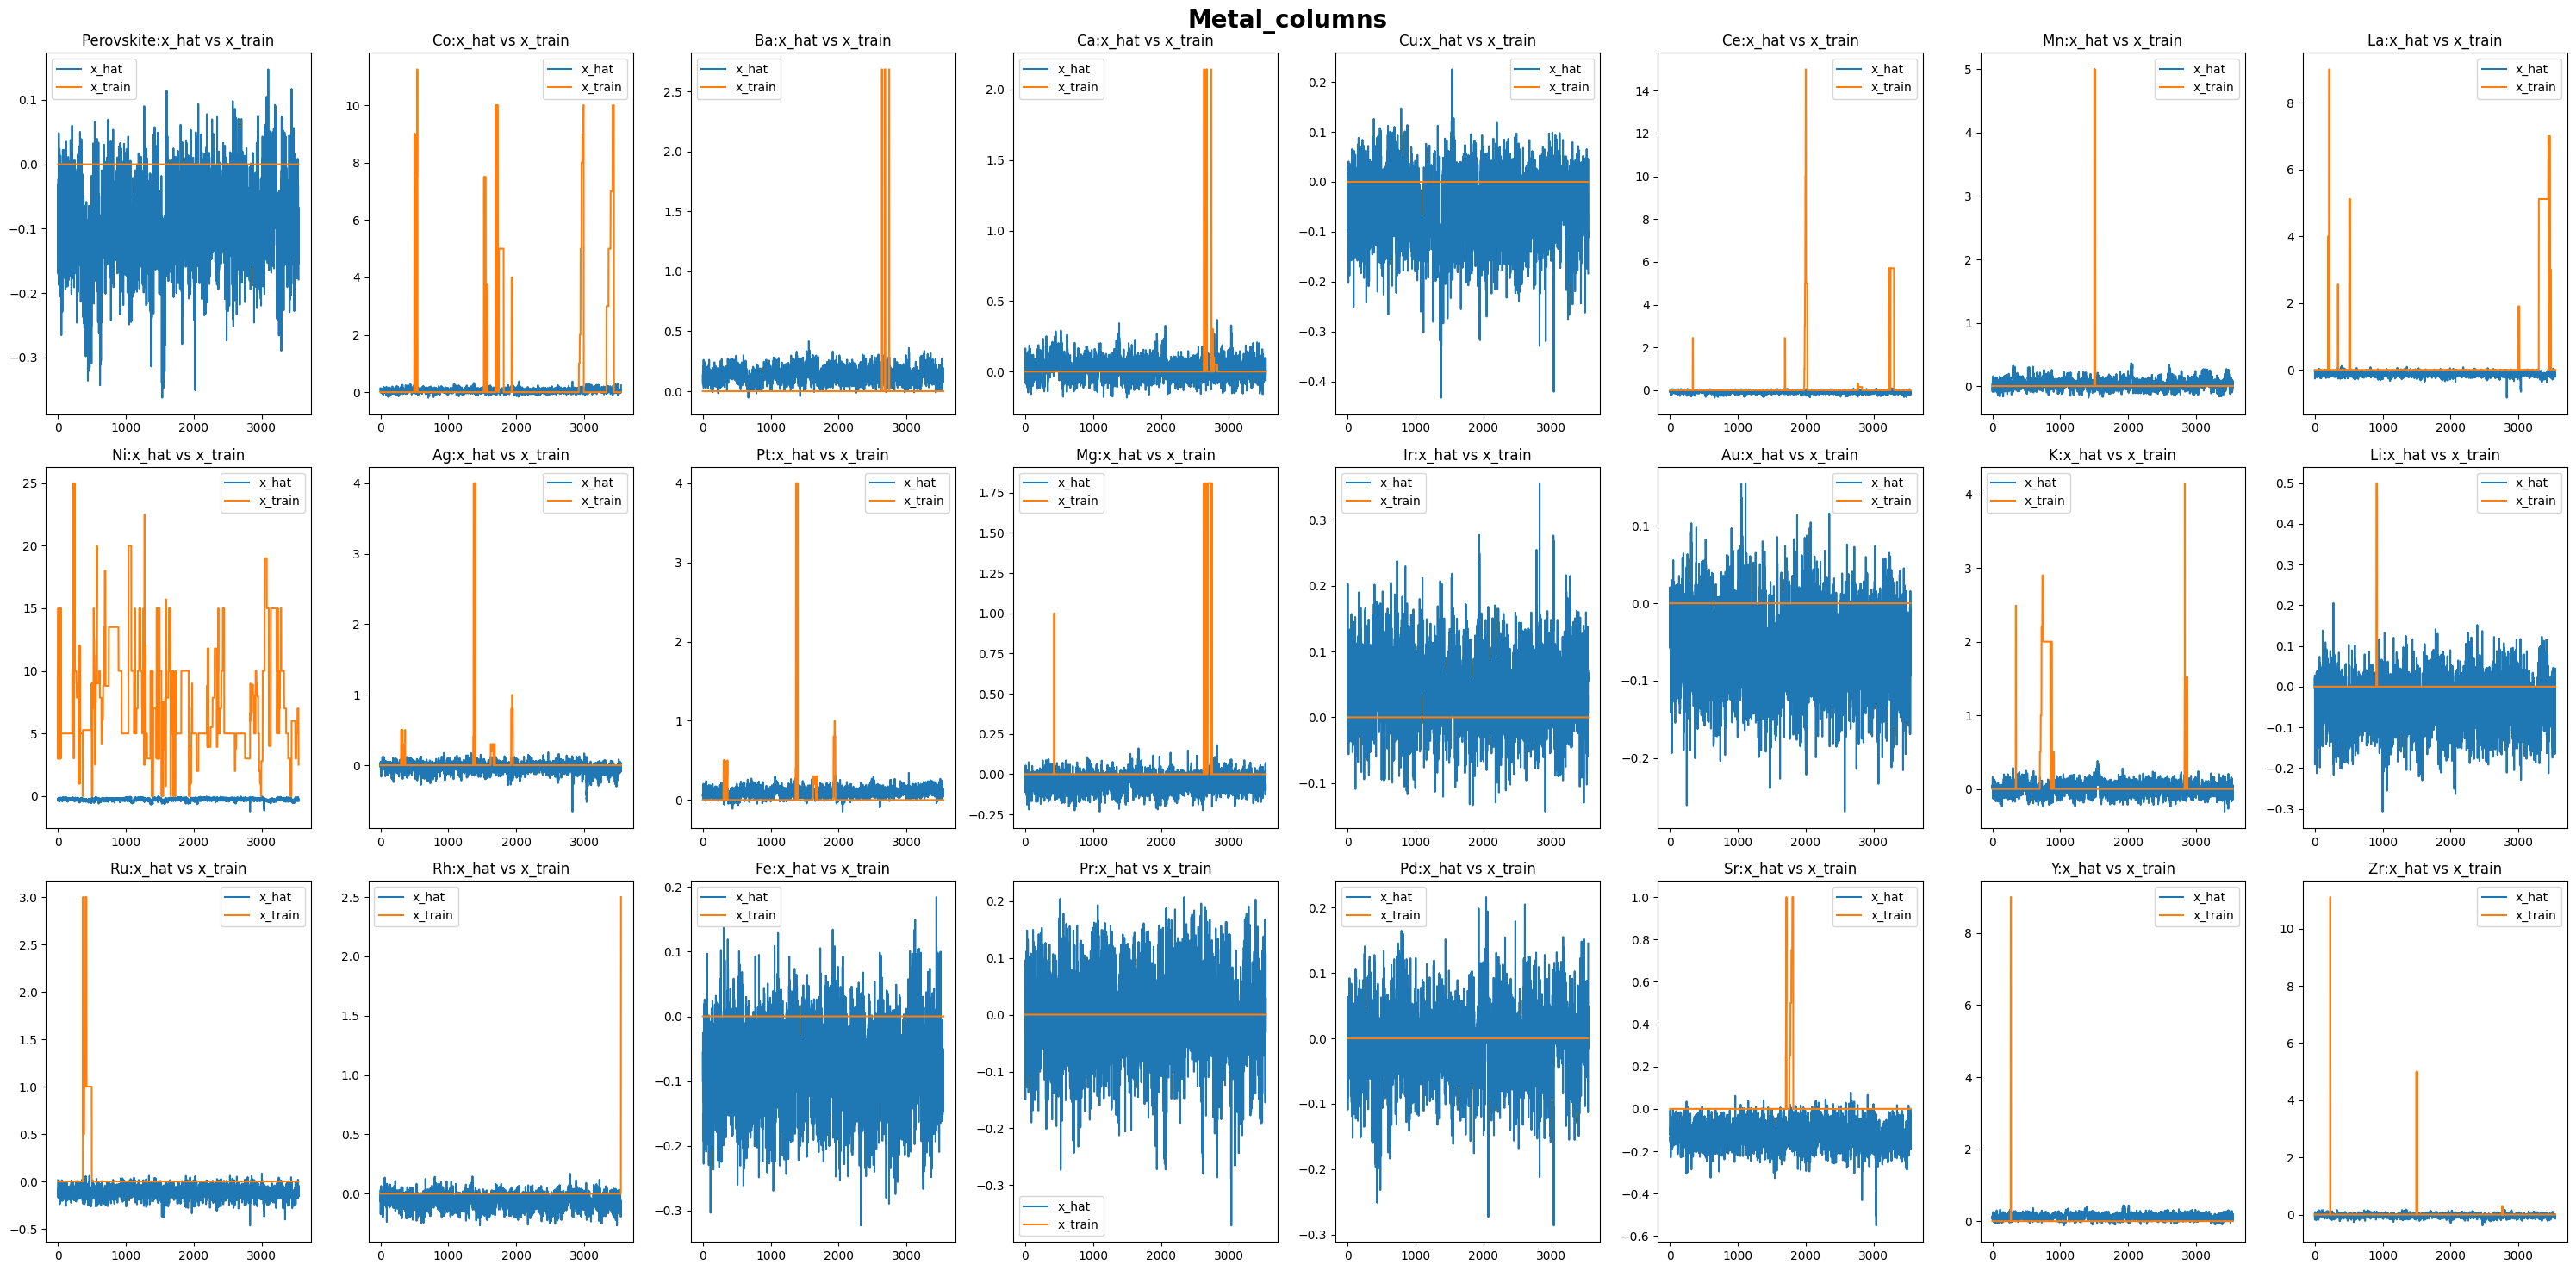

In [ ]:
fig, axes = plt.subplots(x_hat[0].reshape(3,8).detach().cpu().numpy().shape[0],x_hat[1].reshape(3,8).detach().cpu().numpy().shape[1],figsize = (30,15))
axes = axes.flatten()
for i in range(x_hat[0].shape[0]):
    ax = axes[i]
    ax.plot(x_hat[:,i].detach().cpu().numpy(),label = 'x_hat')
    ax.plot(x_train[:,i],label = 'x_train')
    ax.set_title(f'{metal_columns[i]}:x_hat vs x_train')
    ax.legend()
plt.suptitle('Metal_columns',fontsize = 20,fontweight = 'bold')
plt.tight_layout()
plt.show()



## 다시 inverse해서 구하는 방식

In [ ]:
model = CVAE(x_dim = x_dim,c_dim = c_dim,z_dim = 16)
x_hat,mu, logvar = model(x_train,c_train)
x_hat = x_hat.detach().cpu().numpy()
x_hat = scaler_x.inverse_transform(x_hat)
x_hat = torch.tensor(x_hat, dtype=torch.float32)
cvae_loss(x_hat,x_train,mu,logvar,beta = -0.01)

(tensor(3.0212, grad_fn=<AddBackward0>),
 tensor(3.0225),
 tensor(0.1270, grad_fn=<MeanBackward0>))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
learning_rate = 1e-3
z_dim = 16
epochs = 200
train_dataset = TensorDataset(x_train,c_train)
val_dataset = TensorDataset(x_val,c_val)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle = False)


## model에 cuda 연결하기

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

CVAE(
  (enc1): Linear(in_features=33, out_features=128, bias=True)
  (enc2): Linear(in_features=128, out_features=256, bias=True)
  (mu): Linear(in_features=256, out_features=16, bias=True)
  (logvar): Linear(in_features=256, out_features=16, bias=True)
  (dec1): Linear(in_features=25, out_features=128, bias=True)
  (dec2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=24, bias=True)
)

In [ ]:
# 모델의 구조에 대한 생각
from torchsummary import summary

summary(model, input_size=[(x_dim,), (c_dim,)], device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,352
            Linear-2                  [-1, 256]          33,024
            Linear-3                   [-1, 16]           4,112
            Linear-4                   [-1, 16]           4,112
            Linear-5                  [-1, 128]           3,328
            Linear-6                  [-1, 256]          33,024
            Linear-7                   [-1, 24]           6,168
Total params: 88,120
Trainable params: 88,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.34
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


# 어떤 형태로 구성되어있나 생각하기

In [ ]:
model_para = list(model.parameters())
for i in range(len(model_para)):
    print(model_para[i].shape)

torch.Size([128, 33])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16])
torch.Size([128, 25])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([24, 256])
torch.Size([24])


## 학습방법

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 모델 초기화
model = CVAE(x_dim=x_dim, c_dim=c_dim, z_dim=z_dim).to(device)

# Optimizer 설정 (Adam이 일반적으로 가장 무난합니다)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# (1) test_loader (x_test, c_test가 torch tensor로 만들어진 뒤에 실행)
test_loader = DataLoader(
    TensorDataset(x_test, c_test),
    batch_size=128,
    shuffle=False
)

train_losses = []
val_losses = []

early = EarlyStopping(patience=30, min_delta=1e-4)
best_epoch = 0

for epoch in range(1, epochs + 1):
    # --- 학습 ---
    model.train()
    train_total_loss = 0.0

    for batch_x, batch_c in train_loader:
        batch_x = batch_x.to(device)
        batch_c = batch_c.to(device)

        optimizer.zero_grad()
        x_hat, mu, logvar = model(batch_x, batch_c)

        loss, recon, kl = cvae_loss(x_hat, batch_x, mu, logvar, beta=0.01)

        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()

    avg_train_loss = train_total_loss / len(train_loader)

    # --- 검증 ---
    model.eval()
    val_total_loss = 0.0
    with torch.no_grad():
        for v_x, v_c in val_loader:
            v_x = v_x.to(device)
            v_c = v_c.to(device)

            v_hat, v_mu, v_logvar = model(v_x, v_c)
            v_loss, _, _ = cvae_loss(v_hat, v_x, v_mu, v_logvar, beta=0.01)
            val_total_loss += v_loss.item()

    avg_val_loss = val_total_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # --- EarlyStopping 체크 ---
    stop = early.step(avg_val_loss, model)
    if early.best_state is not None and avg_val_loss == early.best:
        best_epoch = epoch

    if stop:
        print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch}, Best val loss: {early.best:.6f}")
        break

# ===== 학습 끝: best 모델 weight로 복원 =====
if early.best_state is not None:
    model.load_state_dict(early.best_state)
model = model.to(device)
model.eval()

# ===== (2) 그 상태에서 prediction =====
x_hat_list = []
mu_list = []
logvar_list = []

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t = x_t.to(device)
        c_t = c_t.to(device)

        x_hat, mu, logvar = model(x_t, c_t)

        x_hat_list.append(x_hat.detach().cpu())
        mu_list.append(mu.detach().cpu())
        logvar_list.append(logvar.detach().cpu())

x_hat_test = torch.cat(x_hat_list, dim=0)     # (N_test, x_dim)
mu_test = torch.cat(mu_list, dim=0)           # (N_test, z_dim)
logvar_test = torch.cat(logvar_list, dim=0)   # (N_test, z_dim)

print("x_hat_test shape:", x_hat_test.shape)

# (선택) test recon MSE 확인
x_true_test = x_test.detach().cpu()
test_mse = F.mse_loss(x_hat_test, x_true_test).item()
print("test recon MSE:", test_mse)


Epoch [1/200] Train Loss: 0.644781 | Val Loss: 7.549162
Epoch [20/200] Train Loss: 0.077402 | Val Loss: 0.718015
Epoch [40/200] Train Loss: 0.058166 | Val Loss: 0.583794
Epoch [60/200] Train Loss: 0.048914 | Val Loss: 0.661093
Early stopping at epoch 67. Best epoch: 37, Best val loss: 0.524680
x_hat_test shape: torch.Size([1182, 24])
test recon MSE: 0.6091210246086121


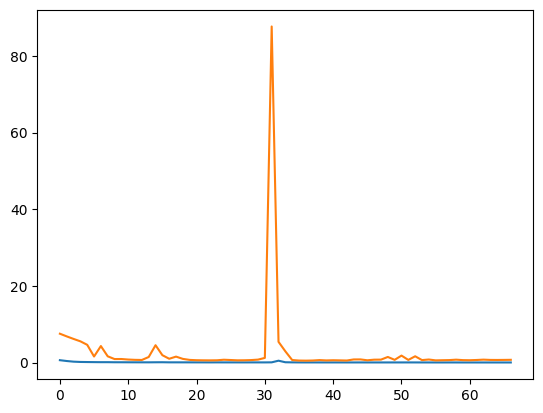

In [ ]:
import matplotlib.pyplot as plt
x_values= torch.arange(len(train_losses))
plt.plot(x_values,train_losses)
plt.plot(x_values,val_losses)

# 실제값과 예측값의 비교

In [ ]:
x_true_test_np = x_true_test.detach().cpu().numpy()
x_test_np = x_hat_test.detach().cpu().numpy()
x_true_test = scaler_x.inverse_transform(x_true_test_np)
x_hat_test = scaler_x.inverse_transform(x_test_np)

In [ ]:
x_true_test[1].shape

(24,)

In [ ]:
df = pd.read_csv('211210-DRM-total.csv')
metal_columns = df.iloc[:,1:25].columns
metal_columns

Index(['Perovskite', 'Co', 'Ba', 'Ca', 'Cu', 'Ce', 'Mn', 'La', 'Ni', 'Ag',
       'Pt', 'Mg', 'Ir', 'Au', 'K', 'Li', 'Ru', 'Rh', 'Fe', 'Pr', 'Pd', 'Sr',
       'Y', 'Zr'],
      dtype='object')

In [ ]:
x_true_test.shape

(1182, 24)

(1182, 24) (1182, 24)


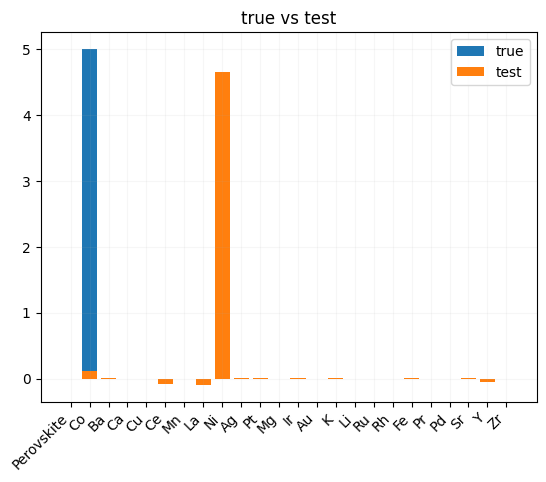

In [ ]:
print(x_true_test.shape,x_true_test.shape)
plt.bar(metal_columns, x_true_test[1],label = 'true')
plt.bar(metal_columns, x_hat_test[1], label = 'test')
plt.legend()
plt.xticks(rotation=45, ha = 'right')
plt.grid(alpha =0.1)
plt.title('true vs test')
plt.show()